<a href="https://colab.research.google.com/github/AliceKitchkin/Forecasting-Rossmann-Store-Sales/blob/main/Forecasting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vorhersagen von Rossmann Store Sales

## Inhaltsverzeichnis <a id="0"></a> <br>
* [Einleitung](#1)
* [Package- und Datenimport](#2)
* [Deskriptive Analyse](#3)
    * [Datenüberblick](#3.1)
    * [Zusammenfassung der statistischen Kenndaten](#3.2)
    * [Analyse der Kategorischen Variablen](#3.3)
    * [Zeitreihenanalyse](#3.4)
    * [Korrelationen](#3.5)
    * [Fehlende Werte und Ausreißer:](#3.6)
* [Daten anpassen](#4)
* [Geeignete Merkmale](#4)
* [ML Verfahren 1](#5)
* [ML Verfahren 2](#6)
* [Vergleich](#7)

## 1. Einleitung <a id="1"></a> <br>

Datenquelle: [kaggle.com](https://www.kaggle.com/competitions/rossmann-store-sales/overview), Ziel dieses Notebooks (Aufgabenstellung) erläutern

## 2. Package- und Datenimport <a id="2"></a> <br>

In [2]:
import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='white') # Hintergrund der Plots

Alle Daten werden importiert und die Spalten sinngemäß übersetzt.

In [3]:
# unzip train-file, to large for github
# train.csv is included in .gitignore
with zipfile.ZipFile("./data/train.zip", "r") as zip:
    zip.extract('train.csv', "./data/")

train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",
                                                        "DayOfWeek":"Wochentag",
                                                        "Date":"Datum",
                                                        "Sales":"Umsatz",
                                                        "Customers":"Kundenanzahl",
                                                        "Open":"Geoeffnet",
                                                        "Promo":"Aktionstag",
                                                        "StateHoliday":"Feiertag",
                                                        "SchoolHoliday":"Schulferien"})

test_original = pd.read_csv("./data/test.csv").rename(columns={"Id":"ID",
                                                      "Store":"Filiale",
                                                      "DayOfWeek":"Wochentag",
                                                      "Date":"Datum",
                                                      "Open":"Geoeffnet",
                                                      "Promo":"Aktionstag",
                                                      "StateHoliday":"Feiertag",
                                                      "SchoolHoliday":"Schulferien"})

store_original = pd.read_csv("./data/store.csv").rename(columns={"Store":"Filiale",
                                                        "StoreType":"Filialentyp",
                                                        "Assortment":"Sortiment",
                                                        "CompetitionDistance":"Wettbewerberentfernung",
                                                        "CompetitionOpenSinceMonth":"Wettbewerber_Eroeffnet_seit_Monat",
                                                        "CompetitionOpenSinceYear":"Wettbewerber_Eroeffnet_seit_Jahr",
                                                        "Promo2": "Teilnahme_Langzeitaktion",
                                                        "Promo2SinceWeek":"Aktion_seit_Woche",
                                                        "Promo2SinceYear":"Aktion_seit_Jahr",
                                                        "PromoInterval":"Aktionsmonate"})

C:\Users\AliceKitchkin\AppData\Local\Temp\ipykernel_25996\2848156393.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv("./data/train.csv").rename(columns={"Store":"Filiale",


Um in einem späteren Zeitpunkt auf die originalen Datensätze zugreifen zu können, werden diese hier separat gespeichert. Außerdem werden die Datensätze _train_original_ und _store_original_ über die Spalte _Filiale_ verbunden und im neuen Datensatz _train_x_store_ gespeichert. Für den Datensatz _test_original_ wird das gleiche Prozedere angewandt.

In [4]:
train = train_original
test = test_original
store = store_original

train_x_store = pd.merge(train, store)
test_x_store = pd.merge(test, store)

## 3. Deskriptive Analyse <a id="3"></a> <br>

### 3.1 Datenüberblick <a id="3.1"></a> <br>

**Train-Datensatz Datenüberblick**

- Struktur des Datensatzes: Überblick über die Anzahl der Zeilen und Spalten.
- Variablenbeschreibung: Liste aller Variablen (Spalten) mit einer kurzen Beschreibung ihrer Bedeutung.

In [5]:
display(train.head())

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


**Test-Datensatz Datenüberblick**

- Struktur des Datensatzes: Überblick über die Anzahl der Zeilen und Spalten.
- Variablenbeschreibung: Liste aller Variablen (Spalten) mit einer kurzen Beschreibung ihrer Bedeutung.

In [6]:
display(test.head())

,ID,Filiale,Wochentag,Datum,Geoeffnet,Aktionstag,Feiertag,Schulferien
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


**Store-Datensatz Datenüberblick**

- Struktur des Datensatzes: Überblick über die Anzahl der Zeilen und Spalten.
- Variablenbeschreibung: Liste aller Variablen (Spalten) mit einer kurzen Beschreibung ihrer Bedeutung.

In [25]:
display(store.head())

,Filiale,Filialentyp,Sortiment,Wettbewerberentfernung,Wettbewerber_Eroeffnet_seit_Monat,Wettbewerber_Eroeffnet_seit_Jahr,Teilnahme_Langzeitaktion,Aktion_seit_Woche,Aktion_seit_Jahr,Aktionsmonate
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


### 3.2 Zusammenfassung der statistischen Kenndaten <a id="3.2"></a> <br>

**Train-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [ ]:
describe = train.describe(include='all')
dtypes = pd.DataFrame(train.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

**Test-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [ ]:
describe = test.describe(include='all')
dtypes = pd.DataFrame(test.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

**Store-Datensatz**

- Deskriptive Statistiken: Mittelwert, Median, Minimum, Maximum, Standardabweichung, Quartile (für numerische Variablen).
- Verteilung der Daten: Histogramme, Boxplots oder Dichteplots zur Visualisierung der Verteilung der numerischen Variablen.

In [ ]:
describe = store.describe(include="all")
dtypes = pd.DataFrame(store.dtypes, columns=["dtypes"]).T
display(pd.concat([dtypes, describe]))

### 3.3 Analyse der Kategorischen Variablen <a id="3.3"></a> <br>

- Häufigkeitsverteilungen: Anzahl der Vorkommen jeder Kategorie (z.B. Anzahl der Filialen, Wochentage, Promotion-Typen).
- Balkendiagramme: Grafische Darstellung der Häufigkeiten.

### 3.4 Zeitreihenanalyse <a id="3.4"></a> <br>

- Trendanalyse: Darstellung des Umsatzes über die Zeit, um Trends, saisonale Muster oder Zyklen zu identifizieren.
- Saisonale Muster: Analyse von Wochen-, Monats- und Jahresmustern.

### 3.5 Korrelationsanalyse <a id="3.5"></a> <br>

- Korrelationsmatrix: Untersuchung der Beziehungen zwischen numerischen Variablen, z.B. Umsatz und Anzahl der Kunden.
- Heatmaps: Visuelle Darstellung der Korrelationen.

TBD
Korrelationswerte   Stärke der Korrelation
0,0 < 0,1	        keine Korrelation
0,1 < 0,3	        geringe Korrelation
0,3 < 0,5	        mittlere Korrelation
0,5 < 0,7	        hohe Korrelation
0,7 < 1,0	        sehr hohe Korrelation

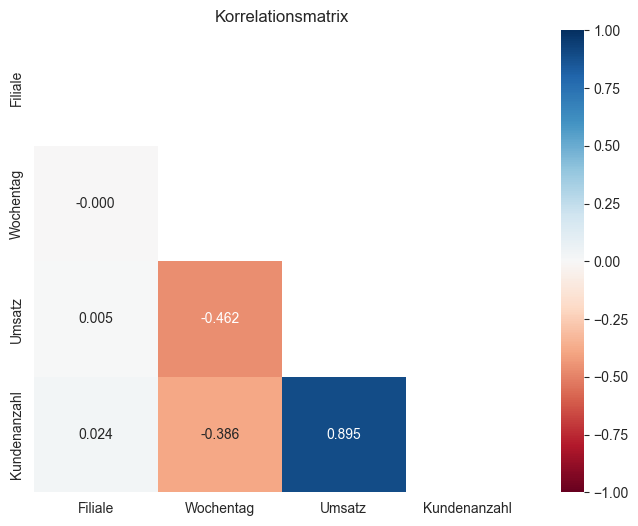

In [31]:
# Spalten mit numerischen Werten
train_only_nr = train.select_dtypes(include=['number'])
corr_matrix = train_only_nr.corr("pearson")
#corr_matrix.style.background_gradient(cmap="Blues", vmin=0, vmax=1)

# Nur unteres Dreieck in der Korrelationsmatrix ziehen
my_mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Korrelationsmatrix erstellen und formatieren
plt.figure(figsize=(8,6))
plot = sns.heatmap(corr_matrix, cmap="RdBu", vmin=-1, vmax=1, annot=True, fmt="0.3f", mask=my_mask)
plot.set_title("Korrelationsmatrix")
plt.show()

### 3.6 Fehlende Werte und Ausreißer <a id="3.6"></a> <br>

- Fehlende Werte: Identifikation und Quantifizierung von fehlenden Datenpunkten.
- Ausreißer: Identifikation von ungewöhnlich hohen oder niedrigen Werten, die nicht dem allgemeinen Muster folgen.

In [30]:
round(train.isnull().sum() / train.shape[0] *100, 2) #Prozent

Filiale         0.0
Wochentag       0.0
Datum           0.0
Umsatz          0.0
Kundenanzahl    0.0
Geoeffnet       0.0
Aktionstag      0.0
Feiertag        0.0
Schulferien     0.0
dtype: float64

#### Datentypen anpassen

In [8]:
dtypes_dict = {"Geoeffnet": bool,
               "Aktionstag": bool,
               "Feiertag": bool,
               "Schulferien": bool}

In [9]:
# Datentypen im Train-Datensatz ändern
train = train.astype(dtypes_dict)
train["Datum"] = pd.to_datetime(train["Datum"])
#train["Wochentag"] = train["Datum"].dt.weekday # Montag=0, Sonntag=6

# Check
print("\nTrain-Datensatztypen nachher")
display(train.dtypes)


Train-Datensatztypen nachher


Filiale                  int64
Wochentag                int64
Datum           datetime64[ns]
Umsatz                   int64
Kundenanzahl             int64
Geoeffnet                 bool
Aktionstag                bool
Feiertag                  bool
Schulferien               bool
dtype: object

#### Tage ohne Umsatz betrachten

Gibt es Datensätze mit 0€ Umsatz? Wenn ja, wann und wieso ist das so?

In [10]:
display(train[train.Umsatz==0.0])

kein_umsatz_anzahl = train[train.Umsatz==0.0].shape[0]

print(str(kein_umsatz_anzahl) + " von " + str(train.shape[0]) + " Zeilen (" + str(round(kein_umsatz_anzahl/train.shape[0]*100,2)) + "%) haben keinen Umsatz.")


,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
291,292,5,2015-07-31,0,0,False,True,True,True
875,876,5,2015-07-31,0,0,False,True,True,True
1406,292,4,2015-07-30,0,0,False,True,True,True
1990,876,4,2015-07-30,0,0,False,True,True,True
2521,292,3,2015-07-29,0,0,False,True,True,True
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,False,False,True,True
1017205,1112,2,2013-01-01,0,0,False,False,True,True
1017206,1113,2,2013-01-01,0,0,False,False,True,True
1017207,1114,2,2013-01-01,0,0,False,False,True,True


172871 von 1017209 Zeilen (16.99%) haben keinen Umsatz.


Wir nehmen uns eine zufällige Filiale und schauen uns an, wann kein Umsatz gemacht wurde

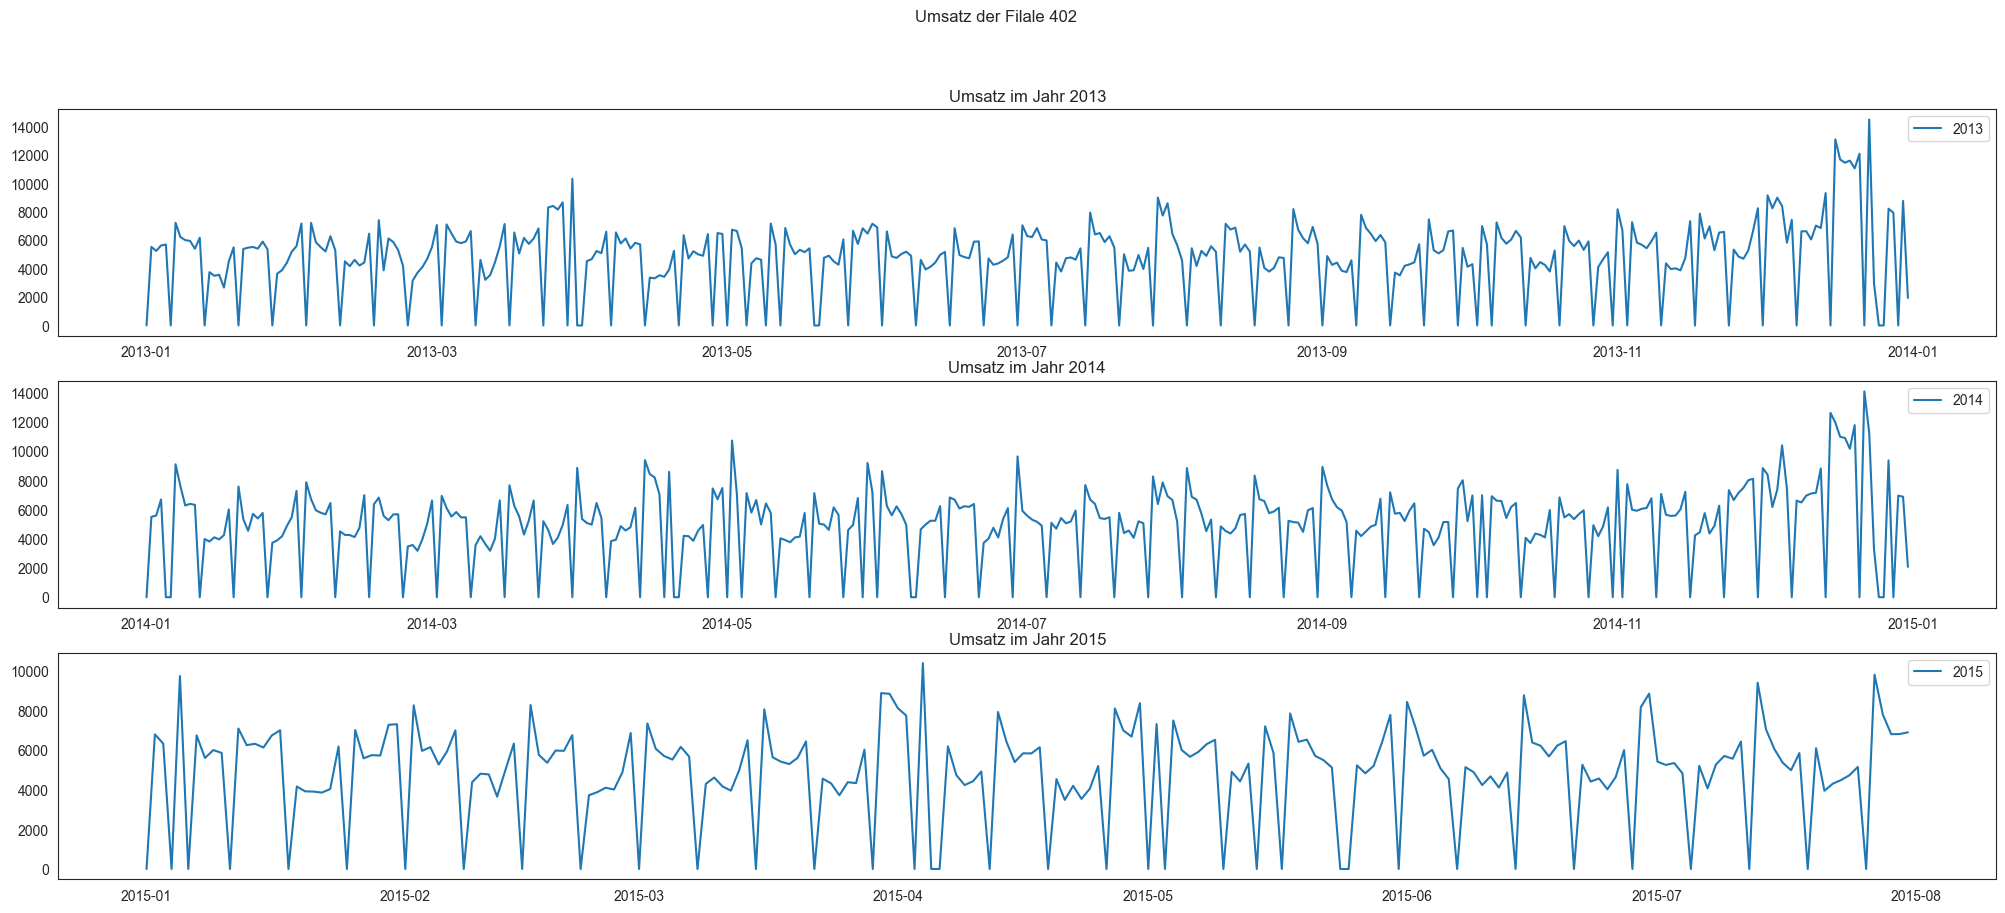

In [11]:
store_id = store["Filiale"].sample(n=1).values[0]
sample = train[train["Filiale"]==store_id].copy()
gp_sample_by_year = sample.groupby(sample["Datum"].dt.year)

fig, axs = plt.subplots(3)
fig.set(figheight = 10, figwidth = 25)
fig.suptitle(f"Umsatz der Filale {store_id}")

for id, sample_year in enumerate(gp_sample_by_year):
    axs[id].plot(sample_year[1]["Datum"], sample_year[1]["Umsatz"], label = sample_year[0])
    axs[id].set_title(f"Umsatz im Jahr {sample_year[0]}")
    axs[id].legend()

plt.show()

In [12]:
# Alle Tage, an denen kein Umsatz gemacht wurde, obwohl die Filiale geöffnet war
kein_umsatz_geoeffnet = train[(train["Umsatz"]==0) & (train["Geoeffnet"]==True)]
kein_umsatz_geoeffnet.head()

,Filiale,Wochentag,Datum,Umsatz,Kundenanzahl,Geoeffnet,Aktionstag,Feiertag,Schulferien
86825,971,5,2015-05-15,0,0,True,False,True,True
142278,674,4,2015-03-26,0,0,True,False,True,False
196938,699,4,2015-02-05,0,0,True,True,True,False
322053,708,3,2014-10-01,0,0,True,True,True,False
330176,357,1,2014-09-22,0,0,True,False,False,False


In [13]:
kein_umsatz_geoeffnet_grouped = kein_umsatz_geoeffnet.groupby(["Wochentag", "Geoeffnet"]).agg(
    Anzahl_Tage=('Umsatz', 'size'),   # Anzahl der Zeilen
    Umsatz=('Umsatz', 'sum')     # Summe der Umsätze
)

kein_umsatz_geoeffnet_grouped

,,Anzahl_Tage,Umsatz
Wochentag,Geoeffnet,,
1,True,3,0
2,True,6,0
3,True,14,0
4,True,18,0
5,True,7,0
6,True,6,0


#### Leere Werte betrachten

## Daten anpassen <a id="4"></a> <br>

In [18]:
print("Test-Datensatztypen vorher")
display(test.dtypes)

# Datentypen im Test-Datensatz ändern
test = test.astype(dtypes_dict)
test["Datum"] = pd.to_datetime(test["Datum"])
test["Wochentag"] = test["Datum"].dt.weekday # Brauchen wir den Wochentag überhaupt noch als Spalte?

# Check
print("\nTest-Datensatztypen nachher")
display(test.dtypes)

Test-Datensatztypen vorher


ID               int64
Filiale          int64
Wochentag        int64
Datum           object
Geoeffnet      float64
Aktionstag       int64
Feiertag        object
Schulferien      int64
dtype: object


Test-Datensatztypen nachher


ID                      int64
Filiale                 int64
Wochentag               int32
Datum          datetime64[ns]
Geoeffnet                bool
Aktionstag               bool
Feiertag                 bool
Schulferien              bool
dtype: object

## Geeignete Merkmale <a id="4"></a> <br>

Definieren Sie geeignete Merkmale (Features) für die Klassifikation/Regression/Clustering. Versuchen Sie dabei, aus den bestehenden Merkmale neue abzuleiten und überlegen Sie sich zusätzliche z.B. mit externen Informationen. 

## Machine Learning Verfahren 1 <a id="5"></a> <br>

### 5.1 XXX <a id="5.1"></a> <br>

### 5.2 Modellgüte <a id="5.2"></a> <br>

## Machine Learning Verfahren 2 <a id="6"></a> <br>

## Vergleich der Machine Learning Verfahren <a id="7"></a> <br>